In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from sklearn.manifold import TSNE
from sklearn.mixture import BayesianGaussianMixture

In [2]:
task_ids = [i for i in range(9)] 

embeddings = dict()
labels = dict()

test_embeddings = dict()
test_labels = dict()

for task_id, scar_id in enumerate(task_ids):
    embeddings[task_id] = dict()
    labels[task_id] = dict()
    
    test_embeddings[task_id] = dict()
    test_labels[task_id] = dict()
    
    for task_id_next, scar_id_next in enumerate(task_ids):
        try:
            task_embedding = np.load(f"../experiments/feedforwardmask_synthetic_continual_er_1111_1.0/feedforwardmask/version_0/task_{task_id}/test_{task_id_next}_train/test_{task_id_next}_train_embeddings.npy", allow_pickle=True)
            print(task_id_next, task_embedding.shape)
            task_embedding = np.reshape(task_embedding, [task_embedding.shape[0], -1])
            embeddings[task_id][task_id_next] = task_embedding
            labels[task_id][task_id_next] = np.full([task_embedding.shape[0]], fill_value=task_id_next)
        except FileNotFoundError as e:
            continue
    
    for task_id_next, scar_id_next in enumerate(task_ids):
        try:
            task_embedding = np.load(f"../experiments/feedforwardmask_synthetic_continual_er_1111_1.0/feedforwardmask/version_0/task_{task_id}/test_{task_id_next}/test_{task_id_next}_embeddings.npy", allow_pickle=True)
            task_embedding = np.reshape(task_embedding, [task_embedding.shape[0], -1])
            test_embeddings[task_id][task_id_next] = task_embedding
            test_labels[task_id][task_id_next] = np.full([task_embedding.shape[0]], fill_value=task_id_next)
        except FileNotFoundError as e:
            continue
    

# Pad embeddings to same length
max_embed_length = 0
for key in embeddings.keys():
    for sub_key in embeddings[key].keys():
        if embeddings[key][sub_key].shape[1] > max_embed_length:
           max_embed_length = embeddings[key][sub_key].shape[1]

for key in embeddings.keys():
    for sub_key in embeddings[key].keys():
        embeddings[key][sub_key] = np.pad(embeddings[key][sub_key], pad_width=((0, 0), (0, max_embed_length - embeddings[key][sub_key].shape[1])))
        test_embeddings[key][sub_key] = np.pad(test_embeddings[key][sub_key], pad_width=((0, 0), (0, max_embed_length - test_embeddings[key][sub_key].shape[1])))
        

0 (36, 62, 64)
1 (35, 62, 64)
2 (56, 59, 64)
3 (57, 59, 64)
4 (47, 63, 64)
5 (44, 63, 64)
6 (57, 59, 64)
7 (34, 62, 64)
8 (44, 63, 64)
0 (36, 62, 64)
1 (35, 62, 64)
2 (56, 59, 64)
3 (57, 59, 64)
4 (47, 63, 64)
5 (44, 63, 64)
6 (57, 59, 64)
7 (34, 62, 64)
8 (44, 63, 64)
0 (36, 62, 64)
1 (35, 62, 64)
2 (56, 59, 64)
3 (57, 59, 64)
4 (47, 63, 64)
5 (44, 63, 64)
6 (57, 59, 64)
7 (34, 62, 64)
8 (44, 63, 64)
0 (36, 62, 64)
1 (35, 62, 64)
2 (56, 59, 64)
3 (57, 59, 64)
4 (47, 63, 64)
5 (44, 63, 64)
6 (57, 59, 64)
7 (34, 62, 64)
8 (44, 63, 64)
0 (36, 62, 64)
1 (35, 62, 64)
2 (56, 59, 64)
3 (57, 59, 64)
4 (47, 63, 64)
5 (44, 63, 64)
6 (57, 59, 64)
7 (34, 62, 64)
8 (44, 63, 64)
0 (36, 62, 64)
1 (35, 62, 64)
2 (56, 59, 64)
3 (57, 59, 64)
4 (47, 63, 64)
5 (44, 63, 64)
6 (57, 59, 64)
7 (34, 62, 64)
8 (44, 63, 64)
0 (36, 62, 64)
1 (35, 62, 64)
2 (56, 59, 64)
3 (57, 59, 64)
4 (47, 63, 64)
5 (44, 63, 64)
6 (57, 59, 64)
7 (34, 62, 64)
8 (44, 63, 64)
0 (36, 62, 64)
1 (35, 62, 64)
2 (56, 59, 64)
3 (57, 59,

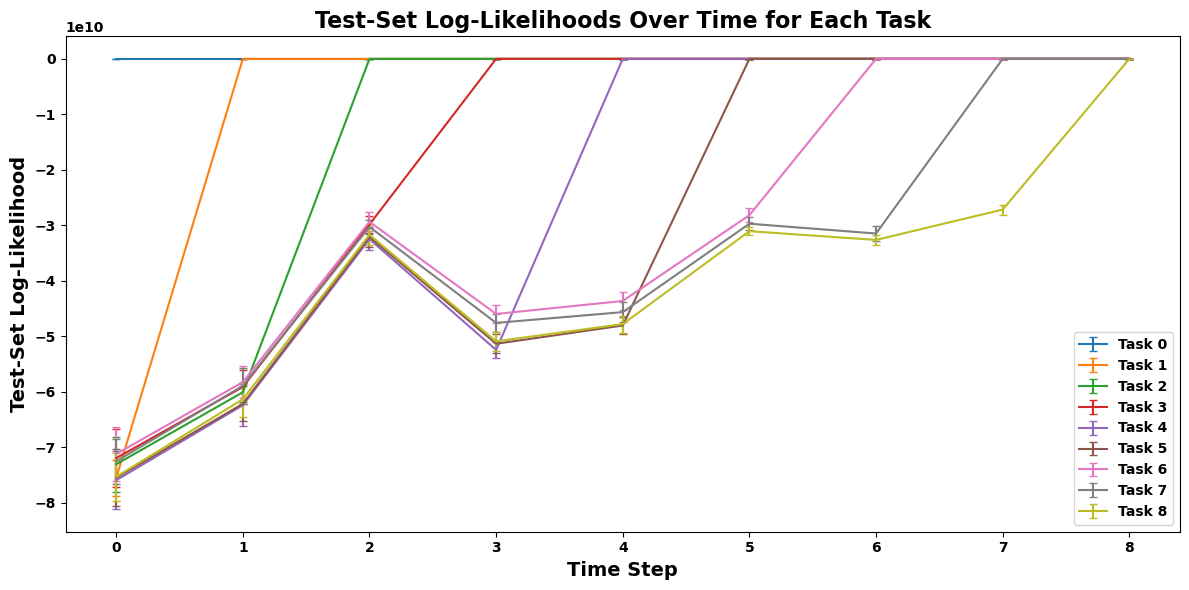

time_step: []
known_ari: []
known_nmi: []
known_log_likelihood: []
known_log_likelihood_std: []
unknown_silhouette: []
unknown_log_likelihood: []
unknown_log_likelihood_std: []


In [3]:
import numpy as np
from scipy.special import softmax
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import matplotlib.pyplot as plt

# Initialize metrics storage
metrics = {
    "time_step": [],
    "known_ari": [],
    "known_nmi": [],
    "known_log_likelihood": [],
    "known_log_likelihood_std": [],
    "unknown_silhouette": [],
    "unknown_log_likelihood": [],
    "unknown_log_likelihood_std": [],
}

# Initialize storage for log-likelihoods and their standard deviations for each task over time
task_log_likelihoods = {task_id: [] for task_id in task_ids}
task_log_likelihood_stds = {task_id: [] for task_id in task_ids}

# Iterate over tasks (time steps)
for time_step in range(len(task_ids)):
    # Prepare data for known tasks
    known_embeddings = []
    known_labels = []
    for task_id in range(time_step + 1):  # Known tasks up to the current time step
        for sub_key in test_embeddings[task_id].keys():
            known_embeddings.append(test_embeddings[task_id][sub_key])
            known_labels.append(test_labels[task_id][sub_key])
    known_embeddings = np.vstack(known_embeddings)
    known_labels = np.concatenate(known_labels)

    # Fit BGMM to known tasks
    bgmm = BayesianGaussianMixture(n_components=time_step + 1, covariance_type='full', random_state=42)
    bgmm.fit(known_embeddings)

    # Predict cluster assignments for known tasks
    known_predictions = bgmm.predict(known_embeddings)

    # Prepare data for unknown tasks
    unknown_embeddings = []
    unknown_labels = []
    for task_id in range(time_step + 1, len(task_ids)):  # Unknown tasks
        for sub_key in test_embeddings[task_id].keys():
            unknown_embeddings.append(test_embeddings[task_id][sub_key])
            unknown_labels.append(test_labels[task_id][sub_key])
    if len(unknown_embeddings) > 0:
        unknown_embeddings = np.vstack(unknown_embeddings)
        unknown_labels = np.concatenate(unknown_labels)

        # Predict cluster assignments for unknown tasks
        unknown_predictions = bgmm.predict(unknown_embeddings)

        # Evaluate log-likelihood for unknown tasks
        unknown_log_likelihoods = bgmm.score_samples(unknown_embeddings)
    else:
        unknown_log_likelihoods = np.array([])
        unknown_predictions = np.array([])

    # Collect log-likelihoods for all tasks at this time step
    valid_log_likelihoods = []
    valid_task_ids = []
    for task_id in task_ids:
        # Check if the task is known or unknown at this time step
        if task_id <= time_step:  # Known tasks
            task_indices = np.where(known_labels == task_id)[0]
            if len(task_indices) > 0:
                task_embeddings = known_embeddings[task_indices]
                task_log_likelihoods_values = bgmm.score_samples(task_embeddings)
                task_log_likelihoods[task_id].append(np.mean(task_log_likelihoods_values))
                task_log_likelihood_stds[task_id].append(np.std(task_log_likelihoods_values))
                valid_log_likelihoods.append(np.mean(task_log_likelihoods_values))
                valid_task_ids.append(task_id)
            else:
                task_log_likelihoods[task_id].append(np.nan)
                task_log_likelihood_stds[task_id].append(np.nan)
        else:  # Unknown tasks
            task_indices = np.where(unknown_labels == task_id)[0] if len(unknown_labels) > 0 else []
            if len(task_indices) > 0:
                task_embeddings = unknown_embeddings[task_indices]
                task_log_likelihoods_values = bgmm.score_samples(task_embeddings)
                task_log_likelihoods[task_id].append(np.mean(task_log_likelihoods_values))
                task_log_likelihood_stds[task_id].append(np.std(task_log_likelihoods_values))
                valid_log_likelihoods.append(np.mean(task_log_likelihoods_values))
                valid_task_ids.append(task_id)
            else:
                task_log_likelihoods[task_id].append(np.nan)
                task_log_likelihood_stds[task_id].append(np.nan)


# Plot log-likelihoods over time for each task with error bars
params = {'font.weight': 'bold'} 
plt.rcParams.update(params)

# Plot log-likelihoods over time for each task with error bars
plt.figure(figsize=(12, 6))
for task_id in task_ids:
    log_likelihoods = np.array(task_log_likelihoods[task_id])
    std_errors = np.array(task_log_likelihood_stds[task_id])
    plt.errorbar(
        range(len(log_likelihoods)),
        log_likelihoods,
        yerr=std_errors,
        label=f"Task {task_id}",
        capsize=3
    )
plt.xlabel("Time Step", fontweight='bold', fontsize=14)
plt.ylabel("Test-Set Log-Likelihood", fontweight='bold', fontsize=14)
plt.title("Test-Set Log-Likelihoods Over Time for Each Task", fontweight='bold', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

# Print metrics over time
for key, values in metrics.items():
    print(f"{key}: {values}")

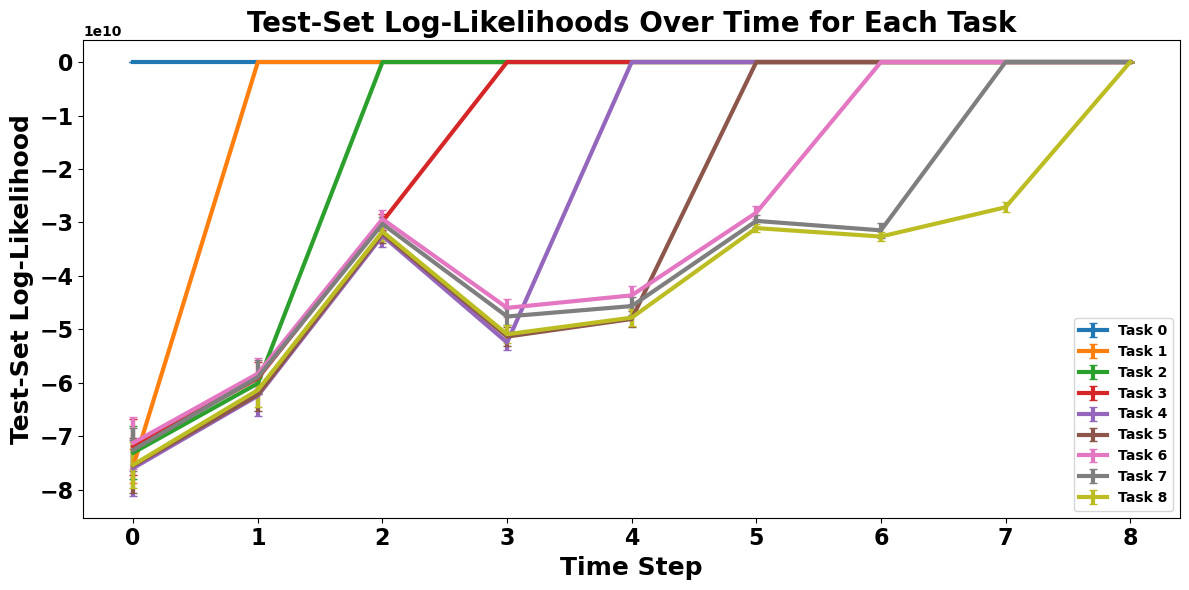

In [12]:
# Plot log-likelihoods over time for each task with error bars
params = {'font.weight': 'bold'} 
plt.rcParams.update(params)

# Plot log-likelihoods over time for each task with error bars
plt.figure(figsize=(12, 6))
for task_id in task_ids:
    log_likelihoods = np.array(task_log_likelihoods[task_id])
    std_errors = np.array(task_log_likelihood_stds[task_id])
    plt.errorbar(
        range(len(log_likelihoods)),
        log_likelihoods,
        yerr=std_errors,
        label=f"Task {task_id}",
        capsize=3,
        linewidth=3
    )
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Time Step", fontweight='bold', fontsize=18)
plt.ylabel("Test-Set Log-Likelihood", fontweight='bold', fontsize=18)
plt.title("Test-Set Log-Likelihoods Over Time for Each Task", fontweight='bold', fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()

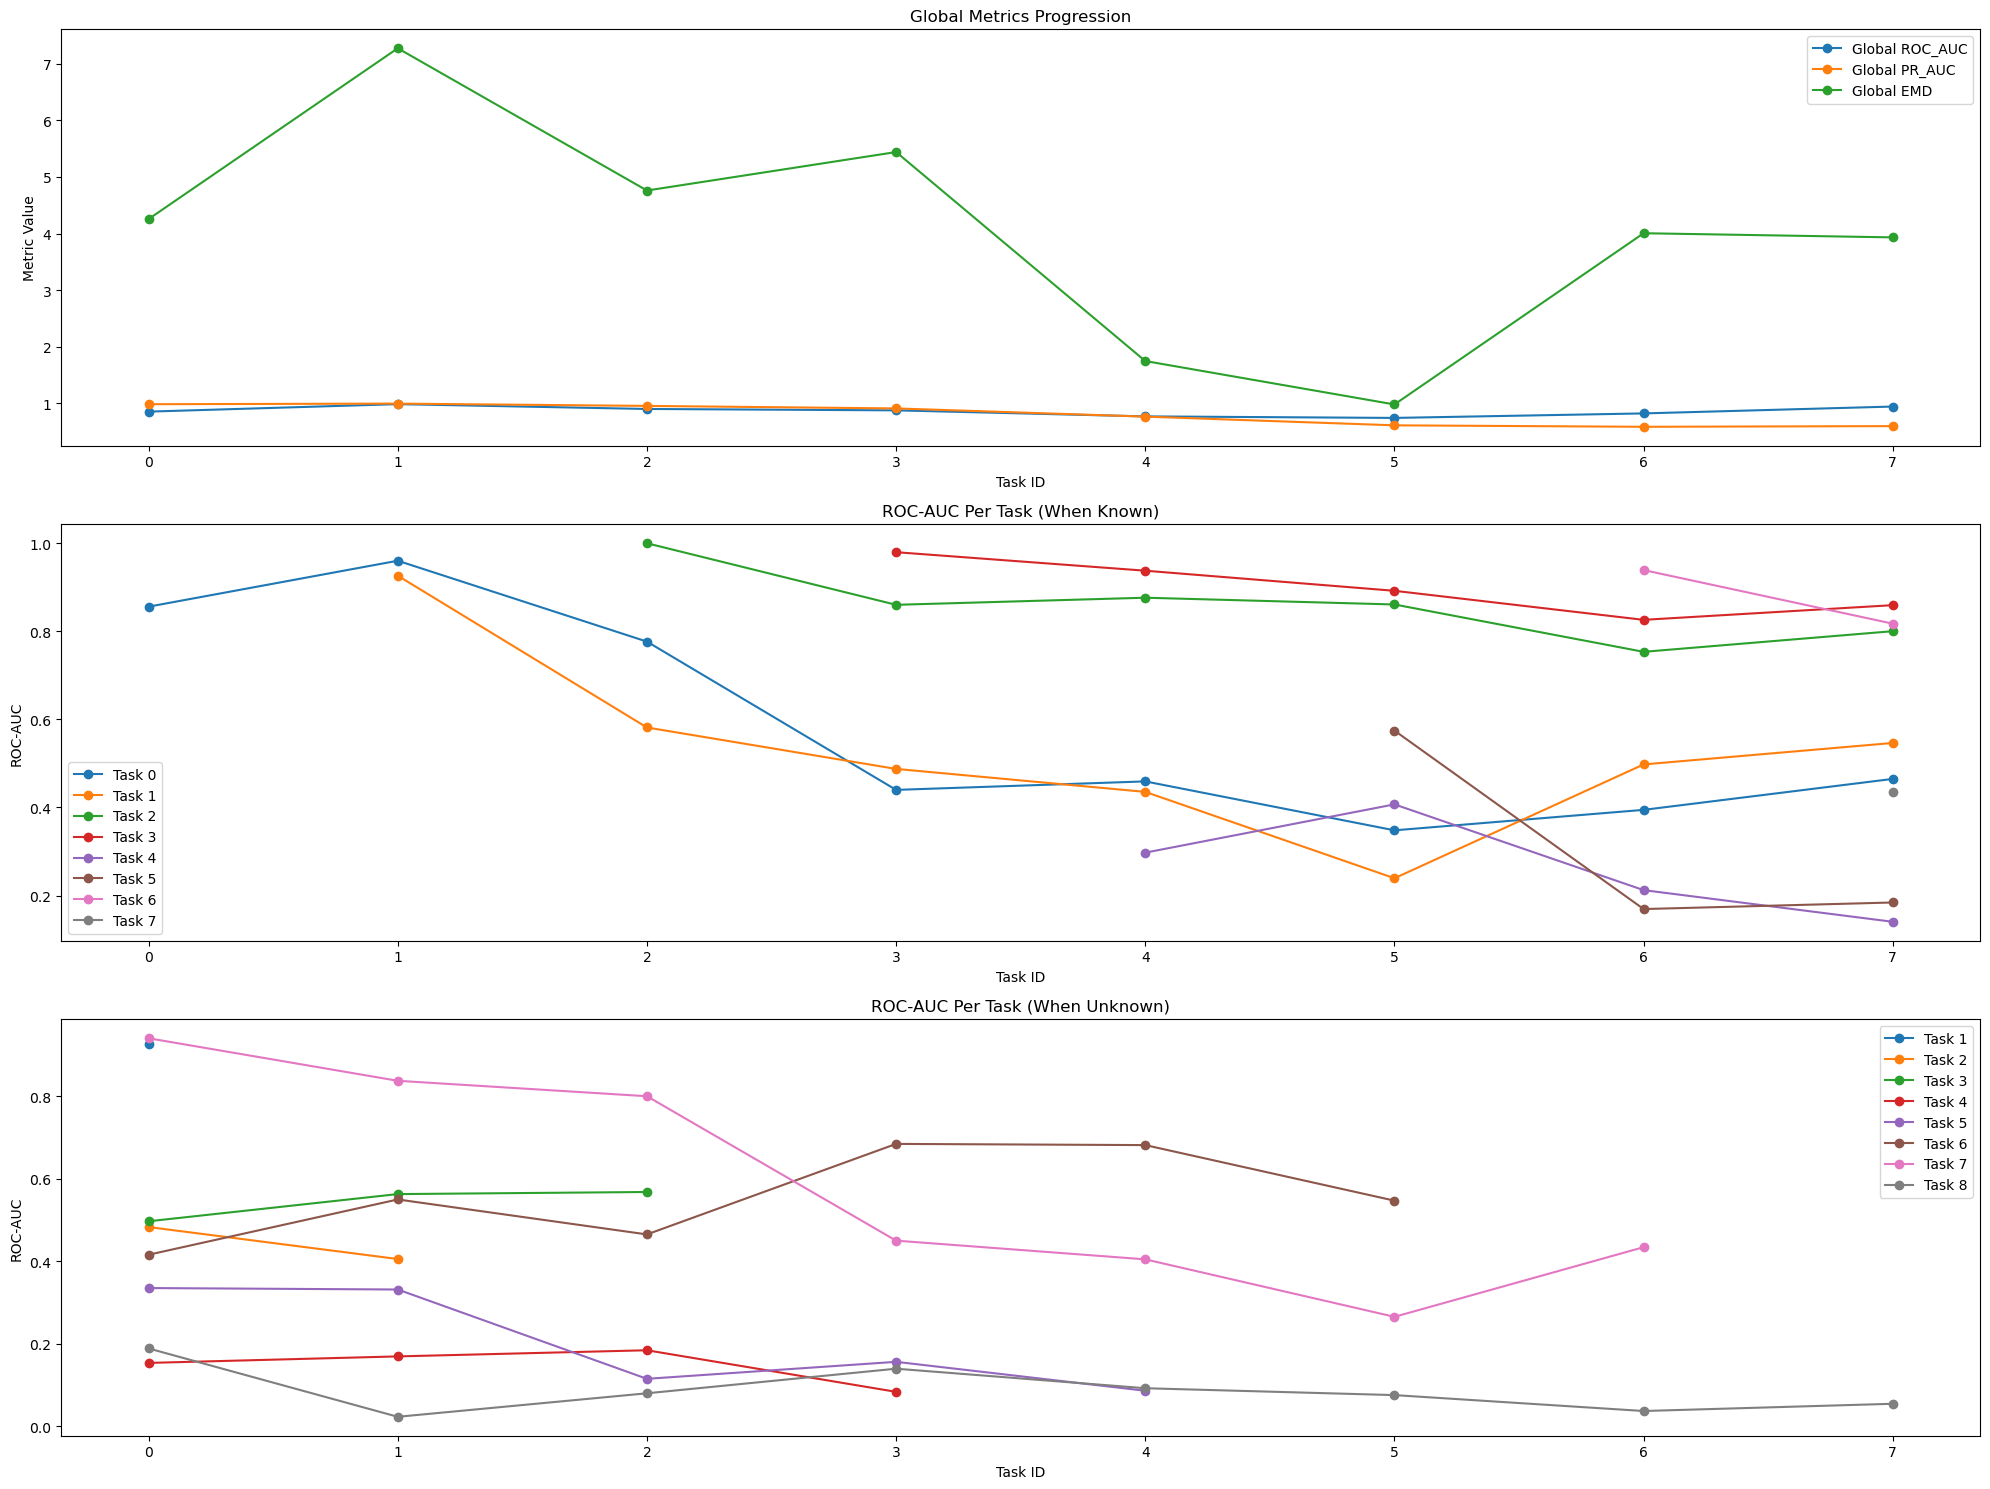


Summary Statistics:

Task 0:
  Known: mean ROC-AUC = 0.587 ± 0.222

Task 1:
  Known: mean ROC-AUC = 0.531 ± 0.191
  Unknown: mean ROC-AUC = 0.927 ± 0.000

Task 2:
  Known: mean ROC-AUC = 0.859 ± 0.076
  Unknown: mean ROC-AUC = 0.444 ± 0.039

Task 3:
  Known: mean ROC-AUC = 0.899 ± 0.055
  Unknown: mean ROC-AUC = 0.543 ± 0.032

Task 4:
  Known: mean ROC-AUC = 0.264 ± 0.099
  Unknown: mean ROC-AUC = 0.148 ± 0.039

Task 5:
  Known: mean ROC-AUC = 0.309 ± 0.188
  Unknown: mean ROC-AUC = 0.205 ± 0.107

Task 6:
  Known: mean ROC-AUC = 0.878 ± 0.061
  Unknown: mean ROC-AUC = 0.557 ± 0.100

Task 7:
  Known: mean ROC-AUC = 0.435 ± 0.000
  Unknown: mean ROC-AUC = 0.591 ± 0.243

Task 8:
  Unknown: mean ROC-AUC = 0.086 ± 0.051


AttributeError: 'MetaEmbeddingEvaluator' object has no attribute 'visualize_embeddings'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from scipy.spatial.distance import cdist
from scipy.stats import wasserstein_distance
from sklearn.mixture import GaussianMixture
import umap

class MetaEmbeddingEvaluator:
    def __init__(self, embeddings, test_embeddings, labels, test_labels):
        self.embeddings = embeddings
        self.test_embeddings = test_embeddings
        self.labels = labels
        self.test_labels = test_labels
        self.metrics = {}
        
    def get_known_unknown_split(self, task_id):
        """Split embeddings into known and unknown tasks based on task_id"""
        known_embeds = []
        known_labels = []
        unknown_embeds = []
        unknown_labels = []
        
        # Get training embeddings
        for i in range(task_id + 1):  # Known tasks
            known_embeds.append(self.embeddings[task_id][i])
            known_labels.extend([i] * len(self.embeddings[task_id][i]))
            
        for i in range(task_id + 1, len(self.embeddings[task_id])):  # Unknown tasks
            unknown_embeds.append(self.embeddings[task_id][i])
            unknown_labels.extend([i] * len(self.embeddings[task_id][i]))
            
        return (np.vstack(known_embeds), np.array(known_labels), 
                np.vstack(unknown_embeds), np.array(unknown_labels))

    def compute_distance_metrics(self, task_id):
        """Compute various distance-based metrics between known and unknown embeddings"""
        known_train, _, unknown_train, _ = self.get_known_unknown_split(task_id)
        
        # Compute minimum distances to known embeddings for both known and unknown test samples
        known_dists = []
        unknown_dists = []
        
        for test_idx in range(len(self.test_embeddings[task_id])):
            test_embeds = self.test_embeddings[task_id][test_idx]
            min_dists = np.min(cdist(test_embeds, known_train), axis=1)
            
            if test_idx <= task_id:  # Known task
                known_dists.extend(min_dists)
            else:  # Unknown task
                unknown_dists.extend(min_dists)
                
        return np.array(known_dists), np.array(unknown_dists)

    def evaluate_task(self, task_id):
        """Evaluate separation between known and unknown tasks for a given task_id"""
        known_dists = []
        unknown_dists = []
        task_specific_metrics = {}

        # Compute distances for each test task separately
        for test_task_id in range(len(self.test_embeddings[task_id])):
            test_embeds = self.test_embeddings[task_id][test_task_id]
            known_train, _, _, _ = self.get_known_unknown_split(task_id)
            
            min_dists = np.min(cdist(test_embeds, known_train), axis=1)
            
            # Store distances by specific task
            if test_task_id <= task_id:  # Known task
                known_dists.extend(min_dists)
                task_specific_metrics[f'task_{test_task_id}'] = {
                    'distances': min_dists,
                    'is_known': True
                }
            else:  # Unknown task
                unknown_dists.extend(min_dists)
                task_specific_metrics[f'task_{test_task_id}'] = {
                    'distances': min_dists,
                    'is_known': False
                }

        # Global metrics
        labels = np.concatenate([np.zeros(len(known_dists)), np.ones(len(unknown_dists))])
        scores = np.concatenate([known_dists, unknown_dists])
        
        fpr, tpr, _ = roc_curve(labels, scores)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(labels, scores)
        pr_auc = average_precision_score(labels, scores)
        emd = wasserstein_distance(known_dists, unknown_dists)

        # Per-task metrics
        for task_key, task_data in task_specific_metrics.items():
            task_dists = task_data['distances']
            other_dists = []
            
            # Collect distances from all other tasks
            for other_key, other_data in task_specific_metrics.items():
                if other_key != task_key:
                    other_dists.extend(other_data['distances'])
                    
            task_labels = np.concatenate([np.zeros(len(task_dists)), np.ones(len(other_dists))])
            task_scores = np.concatenate([task_dists, other_dists])
            
            task_fpr, task_tpr, _ = roc_curve(task_labels, task_scores)
            task_specific_metrics[task_key].update({
                'roc_auc': auc(task_fpr, task_tpr),
                'pr_auc': average_precision_score(task_labels, task_scores),
                'emd': wasserstein_distance(task_dists, other_dists)
            })

        return {
            'global': {
                'roc_auc': roc_auc,
                'pr_auc': pr_auc,
                'emd': emd,
                'known_dists': known_dists,
                'unknown_dists': unknown_dists
            },
            'per_task': task_specific_metrics
        }

    def evaluate_all_tasks(self):
        """Evaluate metrics across all tasks with per-task tracking"""
        results = {}
        task_metrics = {i: {'known': [], 'unknown': []} for i in range(len(self.embeddings))}
        
        for task_id in range(len(self.embeddings) - 1):
            task_results = self.evaluate_task(task_id)
            results[task_id] = task_results
            
            # Track metrics for each individual task
            for task_key, task_data in task_results['per_task'].items():
                task_num = int(task_key.split('_')[1])
                metrics_key = 'known' if task_data['is_known'] else 'unknown'
                task_metrics[task_num][metrics_key].append({
                    'at_task': task_id,
                    'roc_auc': task_data['roc_auc'],
                    'pr_auc': task_data['pr_auc'],
                    'emd': task_data['emd']
                })

        # Plot comprehensive metrics
        self.plot_metric_progression(results, task_metrics)
        
        return results, task_metrics

    def plot_metric_progression(self, results, task_metrics):
        """Plot comprehensive metric progression including per-task tracking"""
        metrics = ['roc_auc', 'pr_auc', 'emd']
        plt.figure(figsize=(20, 15))
        
        # Plot 1: Global metrics
        plt.subplot(3, 1, 1)
        for metric in metrics:
            values = [results[task_id]['global'][metric] for task_id in results]
            plt.plot(values, marker='o', label=f'Global {metric.upper()}')
        plt.title('Global Metrics Progression')
        plt.xlabel('Task ID')
        plt.ylabel('Metric Value')
        plt.legend()
        
        # Plot 2: Per-task metrics when known
        plt.subplot(3, 1, 2)
        for task_id in task_metrics:
            if task_metrics[task_id]['known']:
                values = [x['roc_auc'] for x in task_metrics[task_id]['known']]
                first_known = min(x['at_task'] for x in task_metrics[task_id]['known'])
                x_values = range(first_known, first_known + len(values))
                plt.plot(x_values, values, marker='o', label=f'Task {task_id}')
        plt.title('ROC-AUC Per Task (When Known)')
        plt.xlabel('Task ID')
        plt.ylabel('ROC-AUC')
        plt.legend()
        
        # Plot 3: Per-task metrics when unknown
        plt.subplot(3, 1, 3)
        for task_id in task_metrics:
            if task_metrics[task_id]['unknown']:
                values = [x['roc_auc'] for x in task_metrics[task_id]['unknown']]
                x_values = range(len(values))
                plt.plot(x_values, values, marker='o', label=f'Task {task_id}')
        plt.title('ROC-AUC Per Task (When Unknown)')
        plt.xlabel('Task ID')
        plt.ylabel('ROC-AUC')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\nSummary Statistics:")
        for task_id in task_metrics:
            print(f"\nTask {task_id}:")
            if task_metrics[task_id]['known']:
                known_roc = [x['roc_auc'] for x in task_metrics[task_id]['known']]
                print(f"  Known: mean ROC-AUC = {np.mean(known_roc):.3f} ± {np.std(known_roc):.3f}")
            if task_metrics[task_id]['unknown']:
                unknown_roc = [x['roc_auc'] for x in task_metrics[task_id]['unknown']]
                print(f"  Unknown: mean ROC-AUC = {np.mean(unknown_roc):.3f} ± {np.std(unknown_roc):.3f}")

# Usage example:
evaluator = MetaEmbeddingEvaluator(embeddings, test_embeddings, labels, test_labels)

# Run full evaluation
results = evaluator.evaluate_all_tasks()

# Visualize specific task
task_id = 4  # Example task
evaluator.visualize_embeddings(task_id, method='tsne')
evaluator.plot_distance_distributions(task_id)

(31, 4032) (4, 4032) (334, 4032)


/home/rxm7244/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/rxm7244/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Purity at task 0: mean=1.0000, std=0.0000
(31, 2) (4, 2) (334, 2) (1, 2)


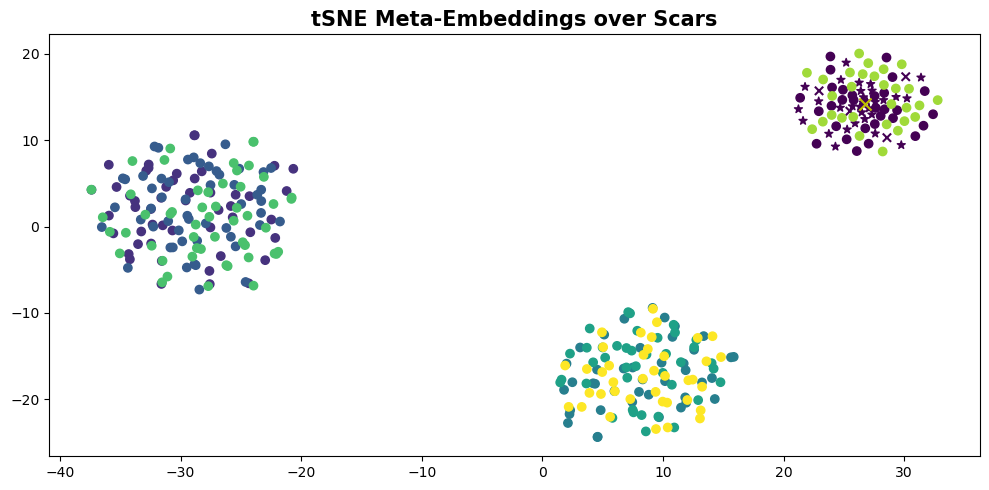

(61, 4032) (8, 4032) (304, 4032)
Purity at task 1: mean=1.0000, std=0.0000
(61, 2) (8, 2) (304, 2) (2, 2)


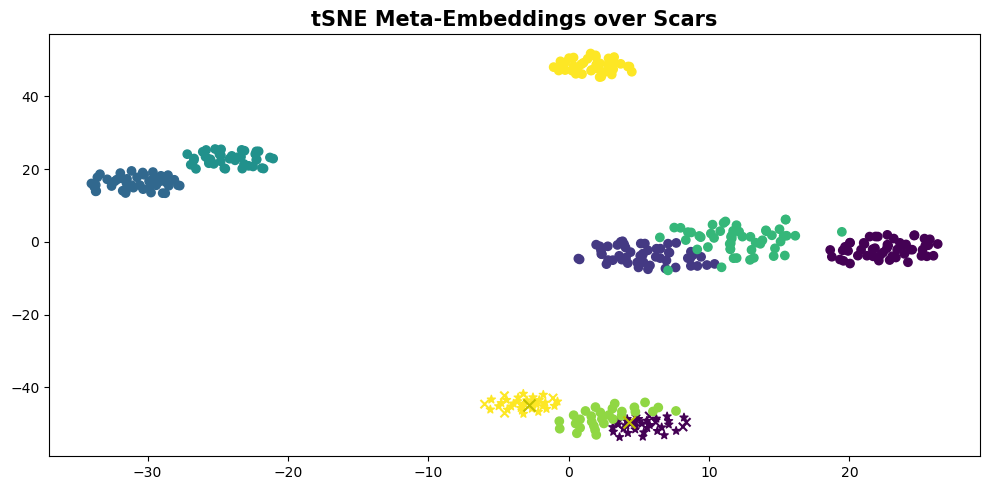

(112, 4032) (17, 4032) (253, 4032)
Purity at task 2: mean=0.7324, std=0.1972
(112, 2) (17, 2) (253, 2) (3, 2)


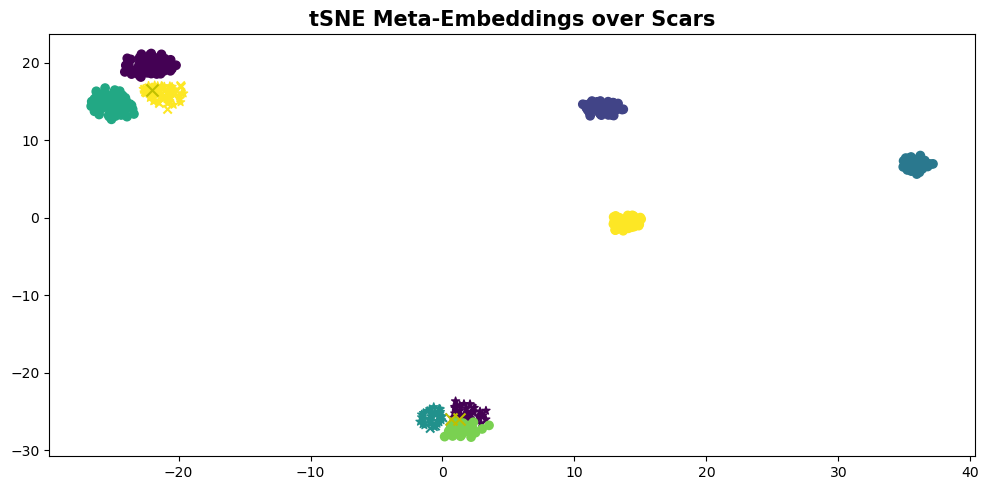

(164, 4032) (27, 4032) (201, 4032)
Purity at task 3: mean=0.9474, std=0.0912
(164, 2) (27, 2) (201, 2) (4, 2)


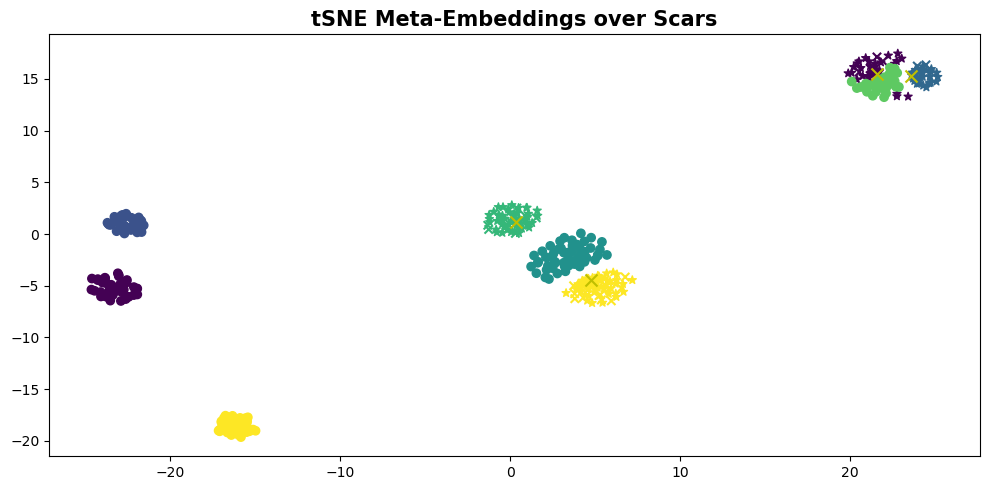

(206, 4032) (34, 4032) (159, 4032)
Purity at task 4: mean=0.9686, std=0.0470
(206, 2) (34, 2) (159, 2) (5, 2)


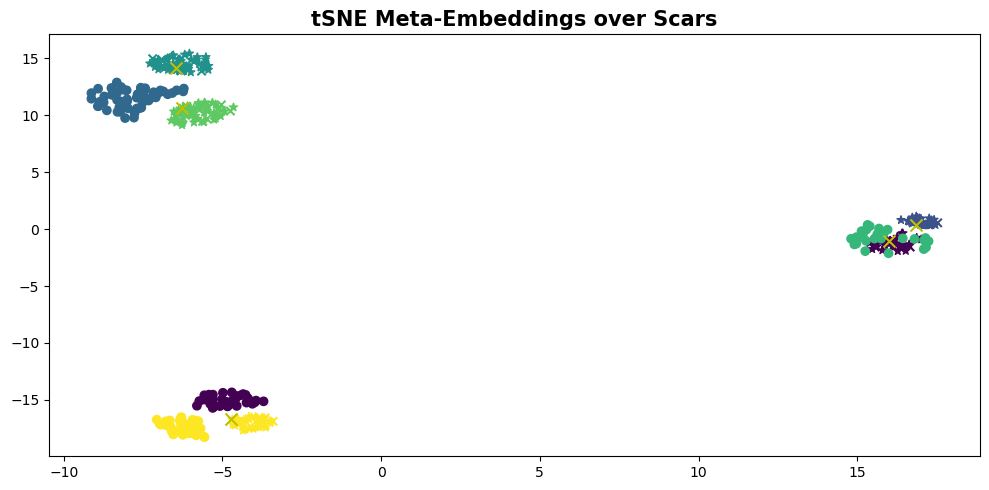

(245, 4032) (41, 4032) (120, 4032)
Purity at task 5: mean=0.8526, std=0.1785
(245, 2) (41, 2) (120, 2) (6, 2)


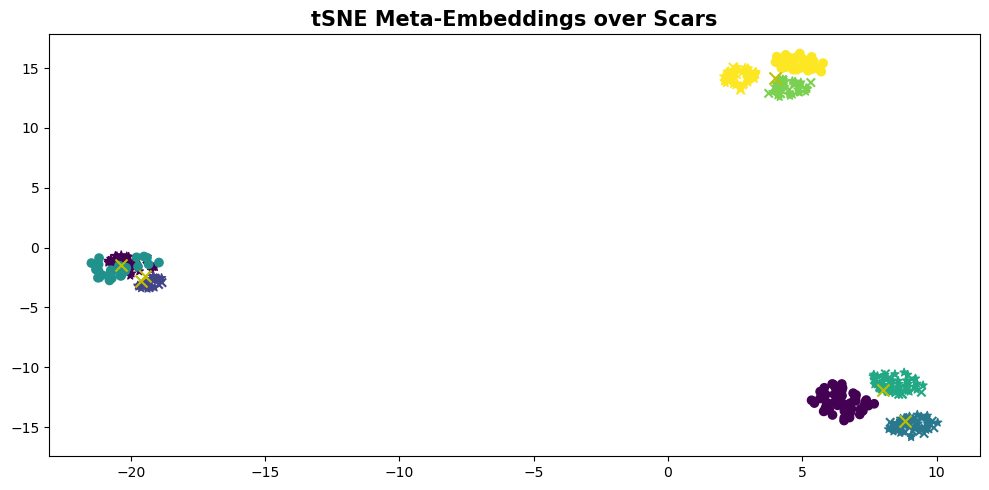

(297, 4032) (51, 4032) (68, 4032)
Purity at task 6: mean=0.8480, std=0.2139
(297, 2) (51, 2) (68, 2) (7, 2)


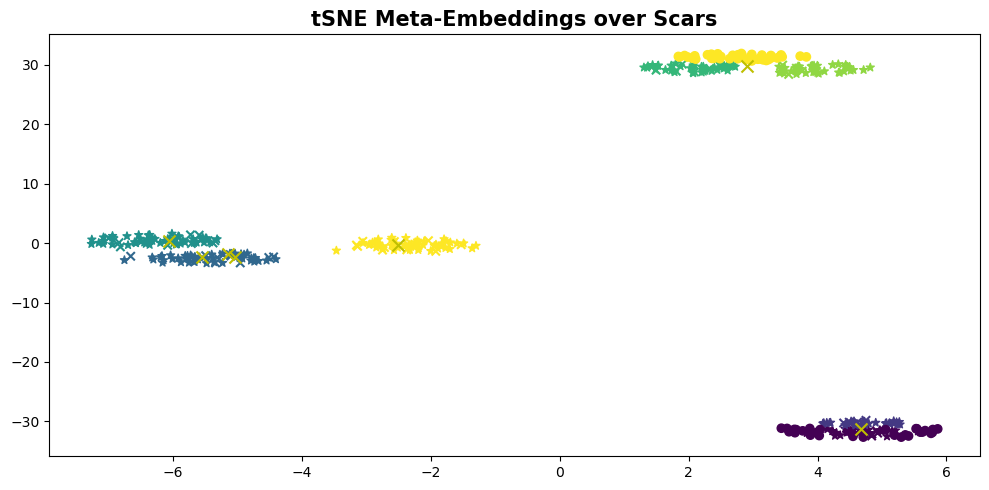

(326, 4032) (55, 4032) (39, 4032)
Purity at task 7: mean=0.7475, std=0.2168
(326, 2) (55, 2) (39, 2) (8, 2)


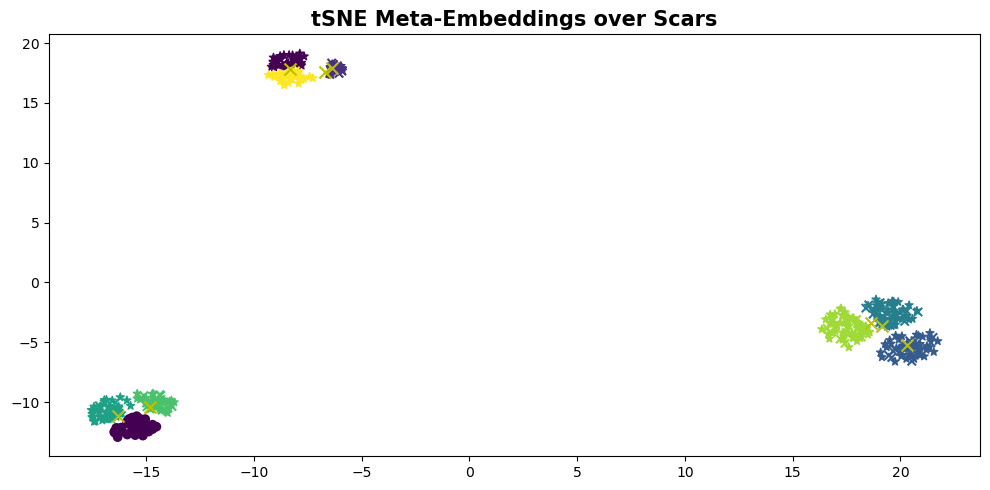

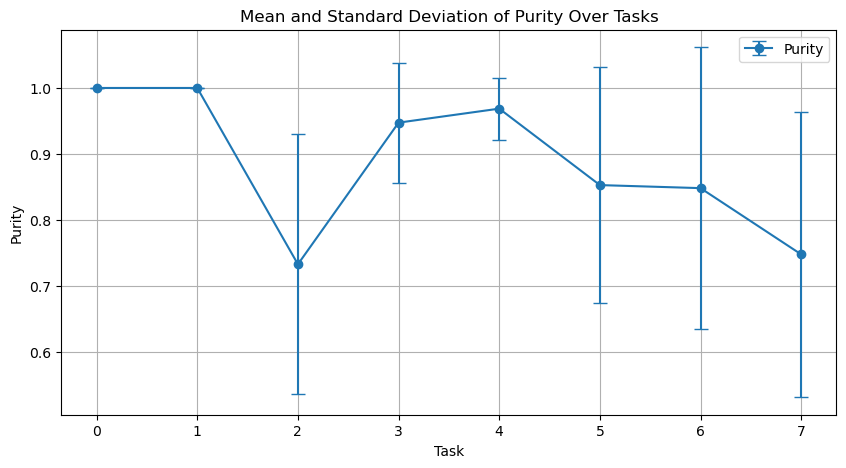

/tmp/ipykernel_1323250/2647776738.py:193: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(range(len(purities)), purities, yerr=stds, fmt='-o', capsize=5, label=f"Task {task_id}", marker='o')


StopIteration: 

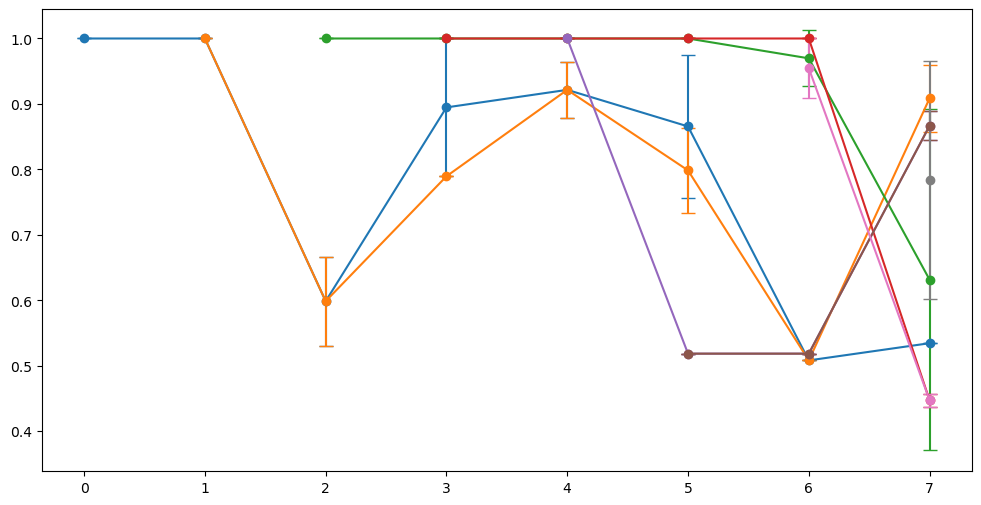

In [ ]:
def refit_clusterer(clusterer, task_counter, combined_embeddings):
    # Fit Bayesian Gaussian Mixture model over the reservoir, taking their cluster assignments as pseudo-labels
    if clusterer is None:
        clusterer = BayesianGaussianMixture(n_components=1, max_iter=1000, n_init=3, random_state=1111)
        clusterer = clusterer.fit(combined_embeddings)
    else:        
        """ Refit with n+1 components with previous components """
        # Save the previous weights
        weights1 = clusterer.weights_
        means1 = clusterer.means_
        covariances1 = clusterer.covariances_

        # Rebuild the GMM, adding on another component
        clusterer = BayesianGaussianMixture(
            n_components=task_counter + 1,
            max_iter=1000, n_init=1, weight_concentration_prior=0.01, random_state=1111
        )

        new_component_mean = np.mean(embeddings[task_counter][task_counter], axis=0)
        new_component_covariance = np.mean(covariances1, axis=0)  # Use the average of the existing covariances

        clusterer.weights_ = np.concatenate([weights1 * (1 - 1e-1), [1e-1]])
        clusterer.means_ = np.vstack([means1, new_component_mean])
        clusterer.covariances_ = np.concatenate([covariances1, [new_component_covariance]])
        clusterer.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(clusterer.covariances_))

        # Do the fit
        clusterer = clusterer.fit(combined_embeddings)
        
        # """ Detect inactive components, throw them out """
        # # Step 2: Detect inactive components (weights close to zero)
        # threshold = 0.05
        # active_indices = np.where(clusterer.weights_ > threshold)[0]

        # # Step 3: Extract parameters of active components
        # active_weights = clusterer.weights_[active_indices]
        # active_means = clusterer.means_[active_indices]
        # active_covariances = clusterer.covariances_[active_indices]

        # # Normalize the weights of the active components
        # active_weights /= active_weights.sum()

        # # Step 4: Initialize a new BayesianGaussianMixture with the number of active components
        # clusterer = BayesianGaussianMixture(
        #     n_components=len(active_indices), max_iter=1000, n_init=1,
        #     weight_concentration_prior=0.01, random_state=1111
        # )

        # clusterer.weights_ = active_weights
        # clusterer.means_ = active_means
        # clusterer.covariances_ = active_covariances
        # clusterer.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(active_covariances))
        # clusterer = clusterer.fit(combined_embeddings)

    return clusterer


from sklearn.metrics import confusion_matrix
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import numpy as np

def calculate_purity(clusterer, embeds, labels):
    """
    Calculate the mean and standard deviation of purity for each cluster in the GMM.
    """
    # Predict cluster assignments
    cluster_assignments = clusterer.predict(embeds)
    
    # Create a confusion matrix
    conf_matrix = confusion_matrix(labels, cluster_assignments)
    
    # Calculate purity for each cluster
    cluster_purities = []
    for cluster_idx in range(conf_matrix.shape[1]):  # Iterate over clusters
        cluster_total = np.sum(conf_matrix[:, cluster_idx])
        if cluster_total > 0:
            cluster_purity = np.max(conf_matrix[:, cluster_idx]) / cluster_total
            cluster_purities.append(cluster_purity)
    
    # Compute mean and standard deviation of cluster purities
    mean_purity = np.mean(cluster_purities)
    std_purity = np.std(cluster_purities)
    
    return mean_purity, std_purity


# Initialize storage for purity metrics
purity_means = []
purity_stds = []

# Initialize storage for average purity and standard deviation per task over the sequence
task_average_purities = {task_id: [] for task_id in task_ids}
task_purity_stds = {task_id: [] for task_id in task_ids}

fit_clusterer = None
for task_counter, task_id in enumerate(embeddings.keys()):
    if task_counter == 8:
        break
    
    known_embed_stack = np.vstack([embeddings[task_id][sub_key] for sub_key in range(len(task_ids[:task_id + 1]))])
    known_label_stack = np.concatenate([labels[task_id][sub_key] for sub_key in range(len(task_ids[:task_id + 1]))])
    
    unknown_embed_stack = np.vstack([embeddings[task_id][sub_key] for sub_key in range(task_id + 1, len(task_ids))])
    unknown_label_stack = np.concatenate([labels[task_id][sub_key] for sub_key in range(task_id + 1, len(task_ids))])
    
    test_known_embed_stack = np.vstack([test_embeddings[task_id][sub_key] for sub_key in range(len(task_ids[:task_id + 1]))])
    test_known_label_stack = np.concatenate([test_labels[task_id][sub_key] for sub_key in range(len(task_ids[:task_id + 1]))])

    print(known_embed_stack.shape, test_known_embed_stack.shape, unknown_embed_stack.shape)
    
    fit_clusterer = refit_clusterer(fit_clusterer, task_counter, known_embed_stack)

    # Calculate purity for the current GMM
    mean_purity, std_purity = calculate_purity(fit_clusterer, known_embed_stack, known_label_stack)
    purity_means.append(mean_purity)
    purity_stds.append(std_purity)
    print(f"Purity at task {task_counter}: mean={mean_purity:.4f}, std={std_purity:.4f}")

    # Predict cluster assignments for the known embeddings
    cluster_assignments = fit_clusterer.predict(known_embed_stack)

    # Create a confusion matrix
    conf_matrix = confusion_matrix(known_label_stack, cluster_assignments)

    # Calculate the purity for each cluster
    cluster_purities = []
    for cluster_idx in range(conf_matrix.shape[1]):  # Iterate over clusters
        cluster_total = np.sum(conf_matrix[:, cluster_idx])
        if cluster_total > 0:
            cluster_purity = np.max(conf_matrix[:, cluster_idx]) / cluster_total
            cluster_purities.append(cluster_purity)

    # Calculate the average purity and standard deviation for each task
    for task in task_ids:  # Iterate over all tasks
        if task <= task_counter:  # Only consider known tasks at this time step
            task_indices = np.where(known_label_stack == task)[0]  # Indices of embeddings for this task
            if len(task_indices) > 0:
                task_clusters = cluster_assignments[task_indices]  # Clusters assigned to this task
                task_cluster_purities = [cluster_purities[cluster] for cluster in np.unique(task_clusters)]
                task_average_purity = np.mean(task_cluster_purities)  # Average purity for this task
                task_purity_std = np.std(task_cluster_purities)  # Standard deviation of purity for this task
            else:
                task_average_purity = np.nan  # No embeddings for this task at this time step
                task_purity_std = np.nan
            task_average_purities[task].append(task_average_purity)
            task_purity_stds[task].append(task_purity_std)
        else:
            # Fill with NaN for tasks not yet known
            task_average_purities[task].append(np.nan)
            task_purity_stds[task].append(np.nan)

    # Get tSNE embeddings
    tsne = TSNE(n_components=2, perplexity=15, metric="cosine", random_state=3, verbose=False)
    tsne_embedding = tsne.fit_transform(np.vstack((known_embed_stack, unknown_embed_stack, test_known_embed_stack, fit_clusterer.means_)))
    
    known_embed_stack = tsne_embedding[:known_embed_stack.shape[0]]
    unknown_embed_stack = tsne_embedding[known_embed_stack.shape[0]:known_embed_stack.shape[0] + unknown_embed_stack.shape[0]]
    test_known_embed_stack = tsne_embedding[known_embed_stack.shape[0] + unknown_embed_stack.shape[0]:known_embed_stack.shape[0] + unknown_embed_stack.shape[0] + test_known_embed_stack.shape[0]]
    means = tsne_embedding[known_embed_stack.shape[0] + unknown_embed_stack.shape[0] + test_known_embed_stack.shape[0]:]
    print(known_embed_stack.shape, test_known_embed_stack.shape, unknown_embed_stack.shape, means.shape)

    # Plot figure
    plt.figure(figsize=(10, 5))

    # Plot the performances over tasks over time
    plt.scatter(known_embed_stack[:, 0], known_embed_stack[:, 1], marker='*', c=known_label_stack)
    plt.scatter(test_known_embed_stack[:, 0], test_known_embed_stack[:, 1], marker='x', c=test_known_label_stack)
    plt.scatter(unknown_embed_stack[:, 0], unknown_embed_stack[:, 1], marker='o', c=unknown_label_stack)
    plt.scatter(means[:, 0], means[:, 1], marker='x', c='y', s=75)

    # Set labels
    plt.title(f"tSNE Meta-Embeddings over Scars", weight='bold', fontsize=15)
    plt.tight_layout()
    plt.show()
    plt.close()

# Plot mean and standard deviation of purity over tasks
plt.figure(figsize=(10, 5))
plt.errorbar(range(len(purity_means)), purity_means, yerr=purity_stds, fmt='-o', capsize=5, label="Purity")
plt.xlabel("Task")
plt.ylabel("Purity")
plt.title("Mean and Standard Deviation of Purity Over Tasks")
plt.legend()
plt.grid()
plt.show()

# Plot the average purity for each task over the task sequence with standard deviation
plt.figure(figsize=(12, 6))
for task_id in task_ids[:-1]:
    purities = task_average_purities[task_id]
    stds = task_purity_stds[task_id]
    plt.errorbar(range(len(purities)), purities, yerr=stds, fmt='-o', capsize=5, label=f"Task {task_id}", marker='o')
plt.xlabel("Task Sequence Index")
plt.ylabel("Average Purity")
plt.ylim(0, 1.1)
plt.title("Average Purity of Each Task Over the Task Sequence with Standard Deviation")
plt.legend()
plt.grid()
plt.show()

/tmp/ipykernel_1323250/2721970047.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(range(len(purities)), purities, yerr=stds, fmt='-o', capsize=5, label=f"Task {task_id}", marker='o')


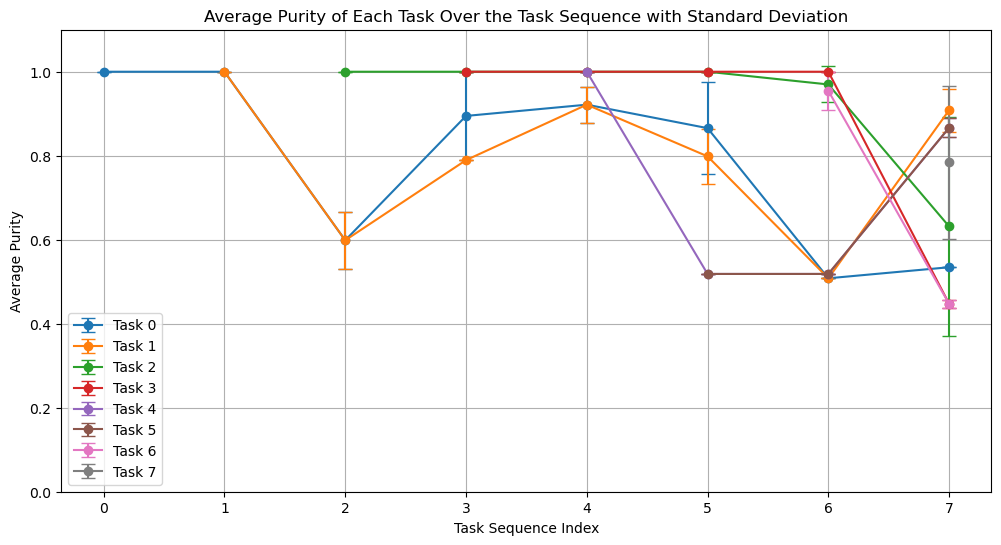

{0: [1.0,
  1.0,
  0.5986394557823129,
  0.8947368421052632,
  0.9215367965367965,
  0.8656565656565657,
  0.5081967213114754,
  0.5344827586206896],
 1: [nan,
  1.0,
  0.5986394557823129,
  0.7894736842105263,
  0.9215367965367965,
  0.7984848484848485,
  0.5081967213114754,
  0.9085714285714286],
 2: [nan, nan, 1.0, 1.0, 1.0, 1.0, 0.9696969696969697, 0.631547619047619],
 3: [nan, nan, nan, 1.0, 1.0, 1.0, 1.0, 0.44732142857142854],
 4: [nan,
  nan,
  nan,
  nan,
  1.0,
  0.5185185185185185,
  0.5185185185185185,
  0.8666666666666667],
 5: [nan,
  nan,
  nan,
  nan,
  nan,
  0.5185185185185185,
  0.5185185185185185,
  0.8666666666666667],
 6: [nan, nan, nan, nan, nan, nan, 0.9545454545454546, 0.44732142857142854],
 7: [nan, nan, nan, nan, nan, nan, nan, 0.7838752052545156],
 8: [nan, nan, nan, nan, nan, nan, nan, nan]}

In [ ]:
# Plot the average purity for each task over the task sequence with standard deviation
plt.figure(figsize=(12, 6))
for task_id in task_ids[:-1]:
    purities = task_average_purities[task_id]
    stds = task_purity_stds[task_id]
    plt.errorbar(range(len(purities)), purities, yerr=stds, fmt='-o', capsize=5, label=f"Task {task_id}", marker='o')
plt.xlabel("Task Sequence Index")
plt.ylabel("Average Purity")
plt.ylim(0, 1.1)
plt.title("Average Purity of Each Task Over the Task Sequence with Standard Deviation")
plt.legend()
plt.grid()
plt.show()

task_average_purities

In [ ]:
task_purity_stds

{0: [0.0,
  0.0,
  0.0680272108843537,
  0.10526315789473684,
  0.04274891774891776,
  0.10887558247813452,
  0.0,
  0.0],
 1: [nan,
  0.0,
  0.0680272108843537,
  0.0,
  0.04274891774891776,
  0.06515151515151518,
  0.0,
  0.0],
 2: [nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.012195121951219523],
 3: [nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.012195121951219523],
 4: [nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0],
 5: [nan, nan, nan, nan, nan, 0.0, 0.0, 0.0],
 6: [nan, nan, nan, nan, nan, nan, 0.0, 0.0],
 7: [nan, nan, nan, nan, nan, nan, nan, 0.0],
 8: [nan, nan, nan, nan, nan, nan, nan, nan]}

In [ ]:
task_average_purities

{0: [1.0,
  1.0,
  0.5986394557823129,
  0.8947368421052632,
  0.9215367965367965,
  0.8656565656565657,
  0.5081967213114754,
  0.5166666666666667],
 1: [nan,
  1.0,
  0.5986394557823129,
  0.7894736842105263,
  0.9215367965367965,
  0.7984848484848485,
  0.5081967213114754,
  1.0],
 2: [nan, nan, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9878048780487805],
 3: [nan, nan, nan, 1.0, 1.0, 1.0, 0.5, 0.9878048780487805],
 4: [nan,
  nan,
  nan,
  nan,
  1.0,
  0.5185185185185185,
  0.5185185185185185,
  0.5185185185185185],
 5: [nan,
  nan,
  nan,
  nan,
  nan,
  0.5185185185185185,
  0.5185185185185185,
  0.5185185185185185],
 6: [nan, nan, nan, nan, nan, nan, 0.5, 1.0],
 7: [nan, nan, nan, nan, nan, nan, nan, 0.5166666666666667],
 8: [nan, nan, nan, nan, nan, nan, nan, nan]}

In [ ]:
embeddings[0].shape